In [0]:
import numpy as np

from keras.models import Sequential,Model
from keras.layers import Convolution2D, ZeroPadding2D, MaxPooling2D, Deconvolution2D, Cropping2D
from keras.layers import Input, Add, Dropout, Permute, add

from google.colab import drive
drive.mount('/content/drive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/


In [0]:
# Function to create to a series of CONV layers followed by Max pooling layer
def Convblock(channel_dimension, block_no, no_of_convs) :
    Layers = []
    for i in range(no_of_convs) :
        
        Conv_name = "conv"+str(block_no)+"_"+str(i+1)
        
        # A constant kernel size of 3*3 is used for all convolutions
        Layers.append(Convolution2D(channel_dimension,kernel_size = (3,3),padding = "same",activation = "relu",name = Conv_name))
    
    Max_pooling_name = "pool"+str(block_no)
    
    #Addding max pooling layer
    Layers.append(MaxPooling2D(pool_size=(2, 2), strides=(2, 2),name = Max_pooling_name))
    
    return Layers

In [0]:
def FCN_8_helper(image_size):
    model = Sequential()
    model.add(Permute((1,2,3),input_shape = (image_size,image_size,3)))
    
    for l in Convblock(64,1,2) :
        model.add(l)
    
    for l in Convblock(128,2,2):
        model.add(l)
    
    for l in Convblock(256,3,3):
        model.add(l)
    
    for l in Convblock(512,4,3):
        model.add(l)
    
    for l in Convblock(512,5,3):
        model.add(l)
        
    model.add(Convolution2D(3072,kernel_size=(7,7),padding = "same",activation = "relu",name = "fc6"))
      
    #Replacing fully connnected layers of VGG Net using convolutions
    model.add(Convolution2D(3072,kernel_size=(1,1),padding = "same",activation = "relu",name = "fc7"))
    
    # Gives the classifications scores for each of the 21 classes including background
    model.add(Convolution2D(22,kernel_size=(1,1),padding="same",activation="relu",name = "score_fr"))
    
    Conv_size = model.layers[-1].output_shape[2] #16 if image size if 512
    #print(Conv_size)
    
    model.add(Deconvolution2D(22,kernel_size=(4,4),strides = (2,2),padding = "valid",activation=None,name = "score2"))
    
    # O = ((I-K+2*P)/Stride)+1 
    # O = Output dimesnion after convolution
    # I = Input dimnesion
    # K = kernel Size
    # P = Padding
    
    # I = (O-1)*Stride + K 
    Deconv_size = model.layers[-1].output_shape[2] #34 if image size is 512*512
    
    #print(Deconv_size)
    # 2 if image size is 512*512
    Extra = (Deconv_size - 2*Conv_size)
    
    #print(Extra)
    
    #Cropping to get correct size
    model.add(Cropping2D(cropping=((0,Extra),(0,Extra))))
    
    return model
    
    

In [0]:
output = FCN_8_helper(480)
print(len(output.layers))





24


In [0]:
output.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
permute_1 (Permute)          (None, 480, 480, 3)       0         
_________________________________________________________________
conv1_1 (Conv2D)             (None, 480, 480, 64)      1792      
_________________________________________________________________
conv1_2 (Conv2D)             (None, 480, 480, 64)      36928     
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 240, 240, 64)      0         
_________________________________________________________________
conv2_1 (Conv2D)             (None, 240, 240, 128)     73856     
_________________________________________________________________
conv2_2 (Conv2D)             (None, 240, 240, 128)     147584    
_________________________________________________________________
pool2 (MaxPooling2D)         (None, 120, 120, 128)    

In [0]:
import keras
def FCN_8(image_size):
    fcn_8 = FCN_8_helper(image_size)
    #Calculating conv size after the sequential block
    #32 if image size is 512*512
    Conv_size = fcn_8.layers[-1].output_shape[2] 
    
    #Conv to be applied on Pool4
    skip_con1 = Convolution2D(22,kernel_size=(1,1),padding = "same",activation=None, name = "score_pool4")
    
    #Addig skip connection which takes adds the output of Max pooling layer 4 to current layer
    Summed = add(inputs = [skip_con1(fcn_8.layers[14].output),fcn_8.layers[-1].output])
    
    #Upsampling output of first skip connection
    x = Deconvolution2D(1,kernel_size=(4,4),strides = (2,2),padding = "valid",activation=None,name = "score4")(Summed)
    x = Cropping2D(cropping=((0,2),(0,2)))(x)
    
    
    #Conv to be applied to pool3
    skip_con2 = Convolution2D(22,kernel_size=(1,1),padding = "same",activation=None, name = "score_pool3")
    
    #Adding skip connection which takes output og Max pooling layer 3 to current layer
    Summed = add(inputs = [skip_con2(fcn_8.layers[10].output),x])
    
    #Final Up convolution which restores the original image size
    Up = Deconvolution2D(22,kernel_size=(16,16),strides = (8,8),
                         padding = "valid",activation = None,name = "upsample")(Summed)
    
    #Cropping the extra part obtained due to transpose convolution
    final = Cropping2D(cropping = ((0,8),(0,8)))(Up)
    softmax = keras.layers.Softmax(axis=-1)(final)
    
    return Model(fcn_8.input, softmax)

In [0]:
model = FCN_8(480)

In [0]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
permute_2_input (InputLayer)    (None, 480, 480, 3)  0                                            
__________________________________________________________________________________________________
permute_2 (Permute)             (None, 480, 480, 3)  0           permute_2_input[0][0]            
__________________________________________________________________________________________________
conv1_1 (Conv2D)                (None, 480, 480, 64) 1792        permute_2[0][0]                  
__________________________________________________________________________________________________
conv1_2 (Conv2D)                (None, 480, 480, 64) 36928       conv1_1[0][0]                    
____________________________________________________________________________________________

In [0]:
import keras
opt = keras.optimizers.adam(lr = 3e-)

In [0]:
model.compile(
    loss='categorical_crossentropy',
    optimizer = opt,
    metrics=['accuracy'])

In [0]:
!pip install gluoncv

     |████████████████████████████████| 512kB 3.5MB/s 


In [0]:
!pip install mxnet

     |████████████████████████████████| 25.4MB 92kB/s 
  Found existing installation: graphviz 0.10.1
    Uninstalling graphviz-0.10.1:
      Successfully uninstalled graphviz-0.10.1


In [0]:
import time
import numpy as np
import mxnet as mx
from mxnet import gluon, autograd
from mxnet.gluon.data.vision import transforms
from gluoncv import data, utils, model_zoo
from gluoncv.utils.parallel import *
from gluoncv.loss import MixSoftmaxCrossEntropyLoss
from matplotlib import pyplot as plt

In [0]:
from google.colab import files
files.upload() 

Saving pascal_voc.py to pascal_voc.py


{'pascal_voc.py': b'"""Prepare PASCAL VOC datasets"""\nimport os\nimport shutil\nimport argparse\nimport tarfile\nfrom gluoncv.utils import download, makedirs\n\n_TARGET_DIR = os.path.expanduser(\'~/.mxnet/datasets/voc\')\n\n\ndef parse_args():\n    parser = argparse.ArgumentParser(\n        description=\'Initialize PASCAL VOC dataset.\',\n        epilog=\'Example: python pascal_voc.py --download-dir ~/VOCdevkit\',\n        formatter_class=argparse.ArgumentDefaultsHelpFormatter)\n    parser.add_argument(\'--download-dir\', type=str, default=\'~/VOCdevkit/\', help=\'dataset directory on disk\')\n    parser.add_argument(\'--no-download\', action=\'store_true\', help=\'disable automatic download if set\')\n    parser.add_argument(\'--overwrite\', action=\'store_true\', help=\'overwrite downloaded files if set, in case they are corrupted\')\n    args = parser.parse_args()\n    return args\n\n#####################################################################################\n# Download a

In [0]:
!python pascal_voc.py

100% 449250/449250 [00:36<00:00, 12214.22KB/s]
100% 440450/440450 [00:34<00:00, 12624.26KB/s]
100% 1952773/1952773 [02:38<00:00, 12289.32KB/s]
1386270KB [00:37, 37154.32KB/s]                 


In [0]:
# input_transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize([.485, .456, .406], [.229, .224, .225]),])
trainset = data.VOCSegmentation(split='train')
print('Training images:', len(trainset))

Training images: 2913


In [0]:
valset = data.VOCSegmentation(split='val')
print('Validation images:', len(valset))

Validation images: 1449


In [0]:
# testset = data.VOCSegmentation(split='test')
# print('Testing images:', len(testset))

In [0]:
import gluoncv
from PIL import Image
import numpy as np
from gluoncv import data, utils
from matplotlib import pyplot as plt

img, mask = trainset[1]
# get pallete for the mask
from gluoncv.utils.viz import get_color_pallete
mask = get_color_pallete(mask.asnumpy())
mask.save('mask.png')

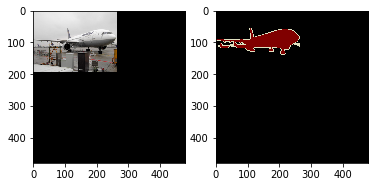

In [0]:
from matplotlib import pyplot as plt
import matplotlib.image as mpimg
# subplot 1 for img
fig = plt.figure()
fig.add_subplot(1,2,1)
plt.imshow(img.asnumpy().reshape(480, 480, 3).astype('uint8'))
# subplot 2 for the mask
mmask = mpimg.imread('mask.png')
fig.add_subplot(1,2,2)
plt.imshow(mmask)
# display
plt.show()

In [0]:
batch_size = 16
train_data = gluon.data.DataLoader(trainset, batch_size, shuffle=True, last_batch='rollover', num_workers=batch_size)

In [0]:
import tensorflow as tf

print(tf.test.is_gpu_available())

False


In [0]:
import gluoncv
from PIL import Image
import numpy as np
from gluoncv import data, utils
from matplotlib import pyplot as plt
from keras.utils.np_utils import to_categorical

for i in range(50):
    print(f'----------{i+1}th New Epoach----------')
    print('\n')
    for batch, (data, target) in enumerate(train_data):
        matrix_data = data.asnumpy()  # (batch, 480, 480, 3)
        matrix_target = target.asnumpy().astype(int)  # (batch, 480, 480)
        matrix_target[matrix_target == -1] = 21  # -1 represents for the unlabled class 
        categorical_labels = to_categorical(matrix_target, num_classes=22)
        model.fit(matrix_data, categorical_labels,  epochs = 3, batch_size = 16)
        # print(model.predict(matrix_data))
        # print(categorical_labels.shape)
        # print(matrix_data.shape)
        # print(matrix_target.shape) 
        # gluoncv.utils.viz.plot_image(matrix_data[0])
        # plt.show()

----------1th New Epoach----------


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Epoch 1/3





16/16 [==============================] - 22s 1s/step - loss: 3.1509 - acc: 0.0703
Epoch 2/3
16/16 [==============================] - 16s 987ms/step - loss: 3.4486 - acc: 0.0560
Epoch 3/3
16/16 [==============================] - 16s 996ms/step - loss: 3.0628 - acc: 0.1014
Epoch 1/3
16/16 [==============================] - 16s 987ms/step - loss: 2.9998 - acc: 0.1016
Epoch 2/3
16/16 [==============================] - 16s 982ms/step - loss: 2.9284 - acc: 0.1430
Epoch 3/3
16/16 [==============================] - 16s 973ms/step - loss: 2.8573 - acc: 0.2516
Epoch 1/3
16/16 [==============================] - 16s 979ms/step - loss: 2.7512 - acc: 0.3145
Epoch 2/3
16/16 [==============================] - 15s 965ms/step - loss: 2.6943 - acc: 0.3554
Epoch 3/3
16/16 [==============================] - 16s 971ms/step - loss: 2.5300 - acc: 0.4257
Epoch 1/3

In [0]:
model.save('/content/drive/My Drive/FCN_vx.h5')